In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from tensorflow.python.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, BatchNormalization, Dense, TimeDistributed, Flatten
from sklearn.feature_selection import mutual_info_regression

In [2]:
df = pd.read_csv("data_for_model.csv")
df.shape

(4018, 23)

In [3]:
df.head(2)

,Unnamed: 0,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,...,humidity,precip,precipcover,cloudcover,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos
0,2014-01-01,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,...,91.5,0.0,0.0,58.3,7.3,2.6,1,1,0.979223,-0.202787
1,2014-01-02,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,...,83.0,0.0,0.0,60.4,10.9,6.4,1,1,0.685818,-0.727773


In [4]:
df["Date"] = df["Unnamed: 0"]
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.set_index("Date", inplace=True)

In [6]:
df.isna().sum()

,0
Station1_CO,0
Station1_NO2,0
Station1_NOx,0
Station1_PM10,0
Station1_SO2,0
Station2_CO,0
Station2_NO2,0
Station2_NOx,0
Station2_O3,158
Station2_PM10,0


In [7]:
features = [col for col in df.columns if col != "Station2_PM10"]
target = "Station2_PM10"

In [8]:
print(df.isnull().sum())
df.fillna(method="ffill", inplace=True)

Station1_CO            0
Station1_NO2           0
Station1_NOx           0
Station1_PM10          0
Station1_SO2           0
Station2_CO            0
Station2_NO2           0
Station2_NOx           0
Station2_O3          158
Station2_PM10          0
Station2_SO2           0
temp                   0
humidity               0
precip                 0
precipcover            0
cloudcover             0
windspeed              0
visibility             0
is_heating_season      0
is_work_day            0
winddir_sin            0
winddir_cos            0
dtype: int64


<ipython-input-8-f8a952a8f4c3>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [9]:
print(df.isnull().sum())

Station1_CO          0
Station1_NO2         0
Station1_NOx         0
Station1_PM10        0
Station1_SO2         0
Station2_CO          0
Station2_NO2         0
Station2_NOx         0
Station2_O3          0
Station2_PM10        0
Station2_SO2         0
temp                 0
humidity             0
precip               0
precipcover          0
cloudcover           0
windspeed            0
visibility           0
is_heating_season    0
is_work_day          0
winddir_sin          0
winddir_cos          0
dtype: int64


In [10]:
# importance = mutual_info_regression(X_train_scaled.reshape(X_train_scaled.shape[0], -1), y_train)
# important_features = [features[i] for i in range(len(importance)) if importance[i] > threshold]

In [11]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()
df_features_scaled = scaler_features.fit_transform(df[features])
df_target_scaled = scaler_target.fit_transform(df[[target]])
df_scaled = np.hstack((df_features_scaled, df_target_scaled))

In [12]:
def create_sequences(data, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

In [13]:
SEQ_LENGTH = 24

X, y = create_sequences(df_scaled, target_index=len(features), seq_length=SEQ_LENGTH)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [14]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    LSTM(200, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(50, return_sequences=False, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [17]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 1.0294 - mae: 0.7256 - learning_rate: 0.0010
Epoch 2/50
  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 1.1238 - mae: 0.8570

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.9237 - mae: 0.6672 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.8427 - mae: 0.6223 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.8265 - mae: 0.6339 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.7527 - mae: 0.5821 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.7140 - mae: 0.5612 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.6706 - mae: 0.5334 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.6519 - mae: 0.5273 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.6096 - mae: 0.4971 - learning_rate: 0.0010
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5836 - mae: 0.4813 - learning_rate: 0.0010
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - 

In [18]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [19]:
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler_target.inverse_transform(y_pred).flatten()

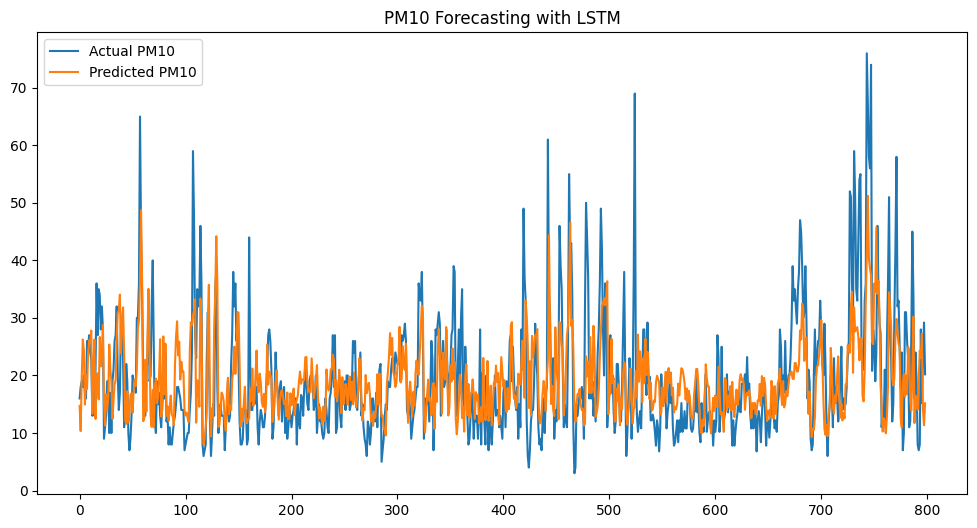

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual PM10')
plt.plot(y_pred_actual, label='Predicted PM10')
plt.legend()
plt.title('PM10 Forecasting with LSTM')
plt.show()

In [21]:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"MAE: {mae}")
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"MSE: {mse}")
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R2: {r2}")

MAE: 6.153355121612549
MSE: 74.30097961425781
R2: 0.3330475553437713
